# pyCTF

pyCTF allows manipulation of experimental contrast transfer functions (CTFs), primarily to measure lens aberrations in transmission electron microscopy (TEM). 

The following objective lens aberrations can be measured:
- Defocus
- Spherical aberration
- Chromatic aberration

Other functionality:
- Remove background noise
- Simulating CTFs (1D and 2D)

## Examples
The examples in this notebook use the images in /assets
First, import the package and dependancies:

In [1]:
import pyCTF
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

invoking __init__.py for pyCTF


## Simulating contrast transfer functions

An thorough dicussion of the mathematics of CTFs can be found in the literature (Brydson, 2011). Briefly, to simulate a CTF as seen in experimental electron micrographs, we need to model the following as functions of spatial frequency ($\bf{u}$):

- Squared phase function, $\chi(\bf{u})^2$
- Aperture function, $A(\bf{u})$
- Spatial coherence envelope, $S(\bf{u})$
- Temporal coherence envelope, $E_t(\bf{u})$

Where $AST$ is the envelope damping function, $E(\bf{u})$. The simulated CTF is then the product of these functions:

$$
CTF^2 = E(\bf{u})\chi(\bf{u})^2
$$

Currently, simulated CTFs allow modelling of the following geometric lens aberrations: 
- Defocus
- Spherical aberration
- Twofold astigmatism

Other modelled parameters:
- Accelerating voltage
- Focal spread
- Chromatic aberration

### 1D CTF simulation

A CTF can be simulated in 1D by calling the CTFSimulation1D class:

invoking __init__.py for pyCTF
defocus (nm): -251.5
C12 (nm, deg): 0.0, 0
Cs (mm): 1.6
Cc (mm):  1.6



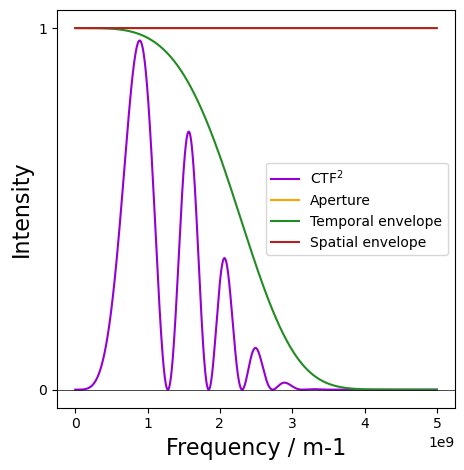

In [1]:
from pyCTF.simulation import CTFSimulation1D

CTF = CTFSimulation1D( 5.0, int(2000), 200, -251.5 )
CTF.plot_ctf()
CTF.print_aberrations()

To update the simulation, first alter the class attributes for lens aberrations, then call the update() method:

defocus (nm): -300.0
C12 (nm, deg): 0.0, 0
Cs (mm): 1.6800000000000002
Cc (mm):  1.6



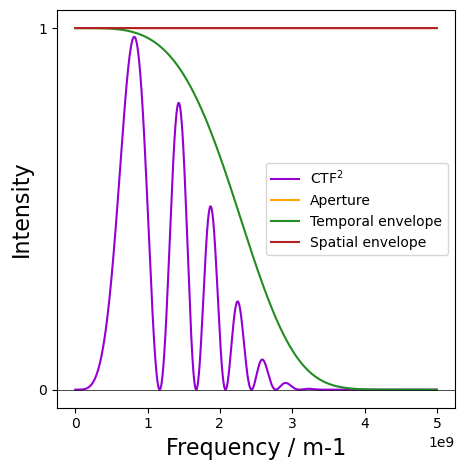

In [2]:
CTF.Cs = 1.68e-3
CTF.defocus = -300e-9
CTF.update()
CTF.plot_ctf()
CTF.print_aberrations()

We can also view each simulated function individually:

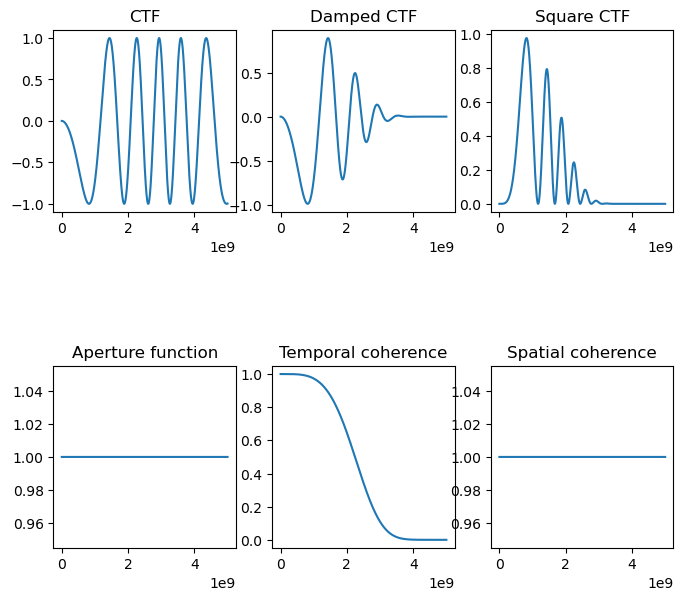

In [4]:
CTF.show_all()

### 2D CTF simulation

To generate a 2D simulation, we use the same process with the CTFSimulation2D class:

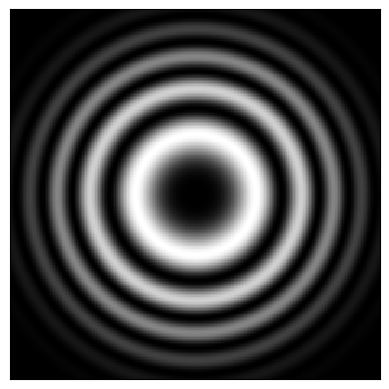

In [5]:
from pyCTF.simulation import CTFSimulation2D
image_size = int(256) # Side length of image in pixels.
acc_voltage = 200 # Accelerating voltage in kV.
max_frequency = 5 # Maximum spatial frequency in nm-1.
defocus = -300 # Defocus in nm.

CTF2D = CTFSimulation2D( max_frequency, image_size, acc_voltage, defocus)
CTF2D.plot_ctf()

It can be updated in the same way:

defocus (nm): -300.00000000000006
C12 (nm, deg): 75.0, 1.9198621771937625
Cs (mm): 1.6
Cc (mm):  1.6

3.701436611487084e-12


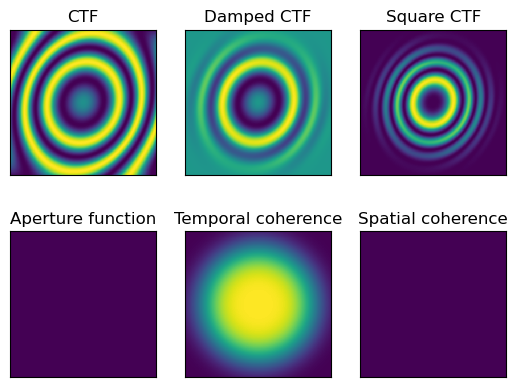

In [6]:
CTF2D.C12a = 75e-9 # Coeffcient of twofold astigmatism in m.
CTF2D.C12b = 10e-9 # Coeffcient of twofold astigmatism in m.
CTF2D.phi = np.deg2rad(110) # Angle of twofold astigmatism in radians.
CTF2D.lamb = pyCTF.misc.kv_to_lamb( 100 ) # Accelerating voltage in kV.

CTF2D.update()

CTF2D.print_aberrations()
CTF2D.show_all()
print(CTF2D.lamb)

## Measuring lens aberrations

### Defocus and spherical aberration

Defocus is measured by extracting and fitting the minima of the CTF (a.k.a. "zeros"). The approach used here is based on the method of Krivanek (Krivanek, 1976) developed by Coene (Coene, 1991), and the description given by Zou (Zou *et al*, 2011).

The spatial frequency of each minima ($u_0$) is extracted, then the following equation is used to plot a straight line: 

$$
\frac{n}{u_0^2}  = \frac{Cs\lambda^2}{2} u + \epsilon
$$

The defocus is given by the y-intercept ($\epsilon$), and gradient can be rearranged for the spherical abberation.

First, import an image into the CTFImage class:

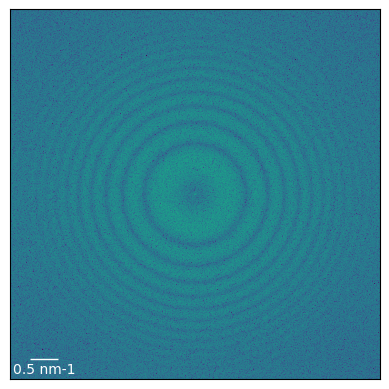

In [7]:
from pyCTF.CTF_image import CTFImage
from pyCTF.misc import show_image

CTF = pyCTF.CTF_image.import_ctf( np.array( Image.open( 'assets\\example_CTF.tif' )), 
											200, 
											0.0066127 )

show_image( CTF.image, scale=CTF.scale )

This example is of an carbon film, recorded on a field-emisson gun TEM at 200 kV.
Next we will remove the background from the CTF using Fourer space methods (Barthel *et al*, 2010). This first removes the low frequency background then the phenomenological envelope function:

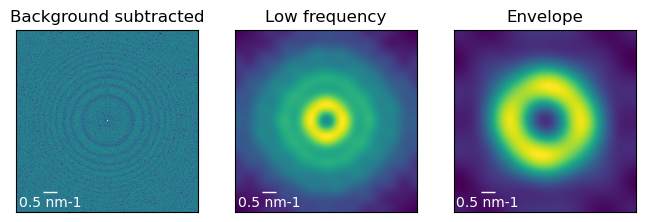

In [8]:
CTF.remove_background( 8, 4 )
CTF.plot_background()

The CTF is then converted to 1D by taking it's radial profile. To extract the zeros of the CTF, the radial profile is cropped to the supplied frequency range, the baseline is subtracted (Baek *et al*, 2015), and Savitsky-Golay smoothing is applied:

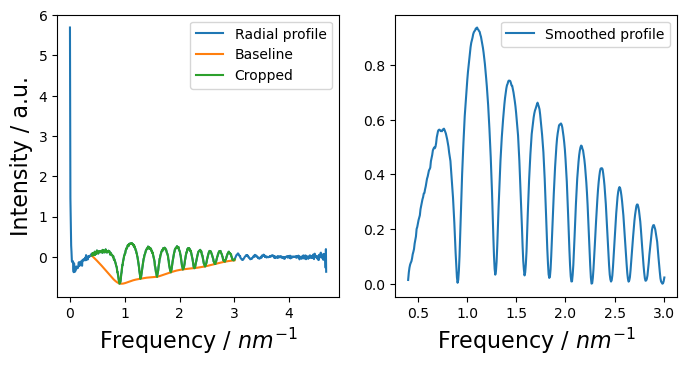

In [9]:
CTF.process_CTF_profile( f_limits=[0.4,3.0],# Frequency range, in nm-1.
                         polynomial=10,# Polynomial for smoothing.
                         window=3 )# Window size for smoothing.
CTF.plot_radial_profiles()

Finally, we use lmfit to find the spherical aberration and defocus. A figure is created showing the fit, and the results are printed to console (controlled via 'verbose' kwarg):

-------------
lmfit results
-------------
[[Model]]
    Model(gradient_simple)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 50
    # data points      = 10
    # variables        = 2
    chi-square         = 1.0071e-04
    reduced chi-square = 1.2588e-05
    Akaike info crit   = -111.058800
    Bayesian info crit = -110.453630
    R-squared          = 0.99663588
[[Variables]]
    m:  0.02118092 +/- 4.3508e-04 (2.05%) (init = -1)
    c: -2.43240134 +/- 0.00236267 (0.10%) (init = 0)


---------------
Fitting results
---------------
Defocus (nm): -484.9412503734127
Spherical aberration (mm): 1.3427539757749367
----------------------
Radial profile
----------------------
Maximum frequency (nm-1): 3.30635
Fitted range x (nm-1): 0.4 - 3.0
Fitted range y:-1.0 - 1.0
------------------------
Savitksy-Golay smoothing
------------------------
Polynomial=15
Window=3
---------------
Detected minima
---------------
|------------------|-------|
| Frequency (nm-1) | Inde

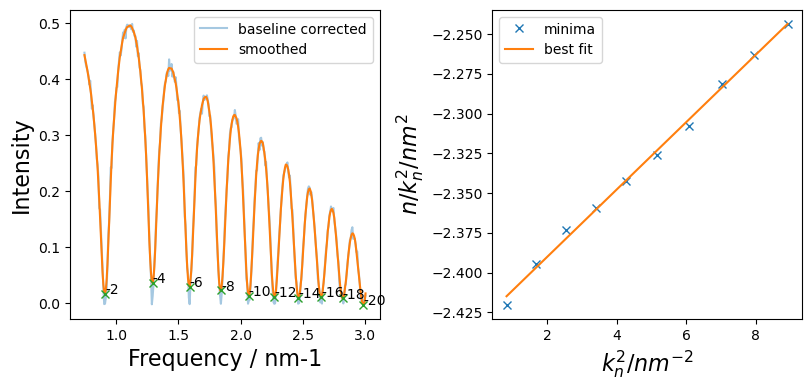

In [11]:
CTF.remove_background( 8, 4 )
CTF.measure_defocus( polynomial=15,# Polynomial for Savitsky-Golay smoothing.
                     window=3,# Window size for Savitsky-Golay smoothing.
                     f_limits=[0.75,3.0],# Range of freqeuncy to fit.
                     underfocus=True,# False for overfocus.
                     xlim=[0.4,3.0],# Exclude all minima outside this range.
                     start=2 )# First index for fitting.
CTF.print_Cs_results( verbose=True )

The detected zeros are marked with a cross, and labelled with their index. For underfocus, we expect the indicies to be negative.

### Chromatic aberration

Chromatic aberration ($C_c$) can be measured using the following relationship (Klemperer, 1971): 

$$
\Delta F = C_c ( \frac{\Delta V}{ V} -  \frac{2\Delta I}{ I }  )
$$

Where $I$ is the objective lens current, $V$ is the accelerating voltage, $\Delta V$ is the voltage instability, and $\Delta F$ is the change in lens focal length. Assuming the objective lens current instability ($\Delta I$) is negligable, measuring the change in defocus as a function of the accelerating voltage gives the chromatic aberration of the objective lens (McMullan *et al*, 2023):

$$
\Delta f = C_c \Delta V
$$

Where $\Delta f$ is the change in defocus. First, declare the defocus and accelerating voltages:

In [8]:
voltage = 200
voltage_data = np.array([199.70, 199.75, 199.80, 199.85, 199.90, 199.95, 200])
defocus_data =   np.array([ -714.09, -433.04, -197.66, 0, 240.20, 458.89, 688.94 ])*1e-9

Then, fit the data using the chromaticAberration class:

[[Model]]
    Model(gradient_simple)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 7
    # variables        = 2
    chi-square         = 2.1893e-15
    reduced chi-square = 4.3787e-16
    Akaike info crit   = -245.907653
    Bayesian info crit = -246.015832
    R-squared          = 0.99851989
[[Variables]]
    m:  9.1869e-04 +/- 1.5818e-05 (1.72%) (init = 1)
    c: -9.1799e-04 +/- 1.5806e-05 (1.72%) (init = 0)
Cc: 0.9186871428572552 mm


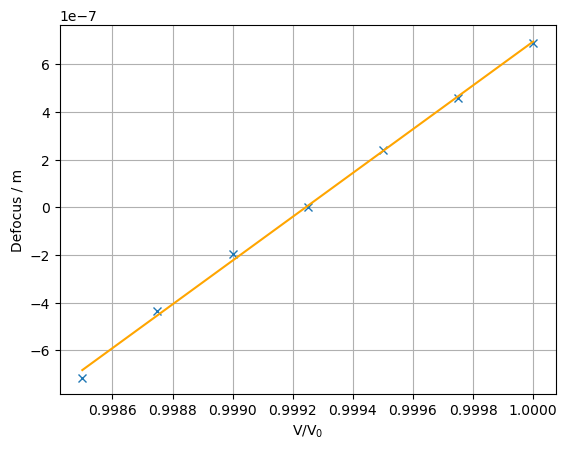

In [9]:
from pyCTF.chromatic_aberration import chromaticAberration
Cc = chromaticAberration( voltage,# Primary accelerating voltage in kV.
                          voltage_data,# Series of accelerating voltages in kV.
                          defocus_data)# Series of defocuses, in m.
fit_method = 'lmfit'
Cc.fit( method=fit_method )
Cc.plot_figure( method=fit_method )
Cc.print_results( method=fit_method )

## Overlaying images

Experimental CTFs can be compared to simulations visually via an overlay. By default the simulated CTF is displayed on the bottom right corner of the new image.

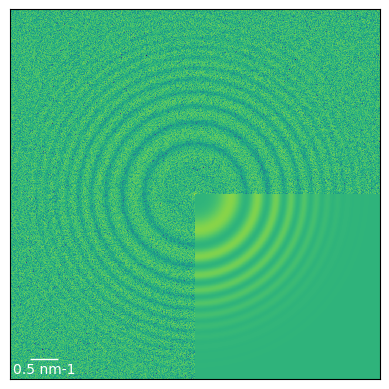

In [13]:
from pyCTF.misc import composite_image, show_image
from pyCTF.simulation import CTFSimulation2D

# First, import the experimental CTF.
CTF = pyCTF.CTF_image.import_ctf( np.array( Image.open( 'assets\\example_CTF.tif' )), 
											200, 
											0.0066127 )
CTF.remove_background(10, 10)
# Then, simulate a 2D CTF.
image_size = CTF.width
acc_voltage = 200
max_frequency = CTF.max_freq_inscribed*2
defocus = -484
simCTF = CTFSimulation2D(max_frequency, image_size, acc_voltage, defocus)
simCTF.Cs=1.3e-3
simCTF.update()

# Then create the overlay.
composite = composite_image( CTF.image,# Base image.
                 simCTF.square_CTF,# Image to overlay.
                 int(CTF.width/2) )# Size of output.
show_image( composite, scale=CTF.scale )

## Manipulating Fourier transforms

### 2D Fourier transform of CTF
pyCTF's Fourier class uses Numpy to perform fast Fourier transforms (FFTs). It can be used to convert a suitable image into a CTF. 

Here, the image is imported and an FFT is performed. The DC freqeuncies are shifted to the middle. The full-sized FFT is then cropped to 300 by 300 pixels to reveal the CTF:

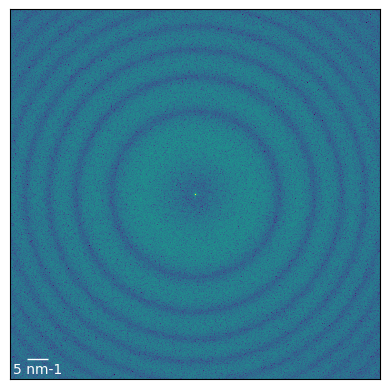

In [18]:
from pyCTF.fourier import Fourier
from pyCTF.misc import show_image

image =  np.array( Image.open( 'assets//example_image.tif' ))
FFT = Fourier.imfft( image )
FFT = Fourier.crop( FFT, 600 )
FFT = Fourier.log_mod( FFT )

show_image( FFT, scale=0.14782, length=5 )

A 2D Fourier transform can be performed on each slice in a stack of images. Using the Fourier.through_focus() method, a real-space image stack is Fourier transformed, converted to real data via log-mod, optionally cropped, the background removed, and it's line profile measured:

In [6]:
from pyCTF.fourier import Fourier
from pyCTF.misc import show_image

stack =  Fourier.import_stack('assets//example_TFS.tif' )
FFT, prof = Fourier.through_focus( stack,
                                   width=60,
                                   r1=5,
                                   r2=5,
                                   verbose=True)


Starting processing through-focus series.
Performing FFT of stack.
Coverting stack to real data.
Center cropping data to range.
Removing background from CTF.
Measuring line profile of stack.
Done.


Text(0.5, 0, 'Frequency / a.u.')

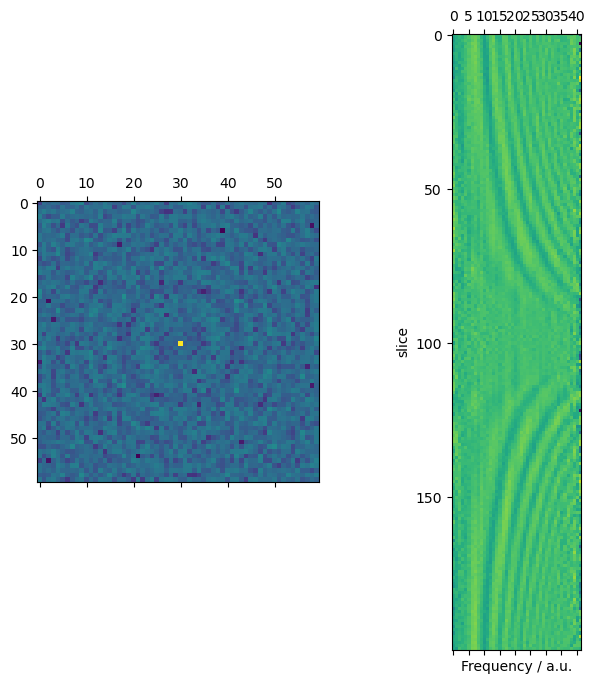

In [39]:
fig, ax = plt.subplots( 1,2, figsize=(8,8) )

ax[0].matshow(FFT[:,:,18], aspect=1)

ax[1].matshow( np.rot90(prof[1:,:]) )

ax[1].set_ylabel('slice')
ax[1].set_xlabel('Frequency / a.u.')

### 3D Fourier transform
In some cases it is useful to perform a 3D FFT of a stack:

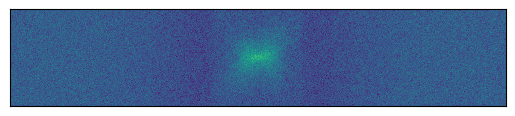

In [40]:
from pyCTF.fourier import Fourier
from pyCTF.misc import show_image

stack =  Fourier.import_stack('assets//example_TFS.tif' )

FFT3D = Fourier.fft3d( stack )
FFT3D = np.log(np.abs(FFT3D))


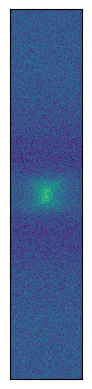

In [47]:
img = np.rot90( FFT3D, k=1, axes=(1, 2) )
img = np.sum( img[:,:,:], 2 )

show_image( img )

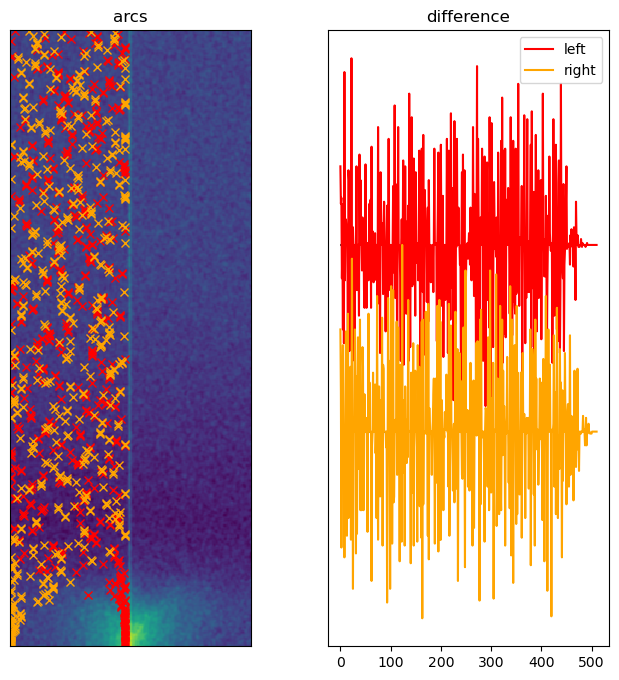

In [48]:
output, filtered = Fourier.measure_arcs( img, 4 )
Fourier.plot_arcs( filtered, output )

In [ ]:
fig, ax = plt.subplots( 1,2, figsize=(8,8) )

ax[0].matshow( img )
ax[1].set_ylabel('slice')
ax[1].set_xlabel('Frequency / a.u.')

## Experimental details

Transmission electron microscopy was performed at 200 kV on a JEOL 2100F TEM with a Gatan Model 1027 K3-IS direct detection camera with DigitalMicrograph software (v3.60). CTFs were acquired ultra-thin carbon film on copper mesh TEM grids (EM Resolutions). Images were converted from .dm4 format to .tiff format using ImageJ or DigitalMicrograph.

## Acknowledgements

This work was supported by the EPSRC \[EP/W006413/1 and EP/L022494/1].

## Citations
- Baek SJ, Park A, Ahn YJ, Choo J. Baseline correction using asymmetrically reweighted penalized least squares smoothing. The Analyst. 2015;140(1):250–7.
- Barthel J, Thust A. Aberration measurement in HRTEM: Implementation and diagnostic use of numerical procedures for the highly precise recognition of diffractogram patterns. Ultramicroscopy. 2010 Dec;111(1):27–46.
- Brydson R, editor. Aberration-corrected analytical transmission electron microscopy. Chichester, West Sussex: RMS-Wiley; 2011.
- Coene WMJ, Denteneer TJJ. Improved methods for the determination of the spherical aberration coefficient in high-resolution electron microscopy from micrographs of an amorphous object. Ultramicroscopy. 1991 Dec;38(3–4):225–33.
- Klemperer OE, Barnett ME. Electron optics. Third ed., first paperback ed. Cambridge: Cambridge Univ. Press; 2010. 506 p. (Cambridge monographs on physics).
- Krivanek OL, Gaskell PH, Howie A. Seeing order in ‘amorphous’ materials. Nature. 1976 Aug;262(5568):454–7.
- McMullan G, Naydenova K, Mihaylov D, Yamashita K, Peet MJ, Wilson H, et al. Structure determination by cryoEM at 100 keV. Proc Natl Acad Sci. 2023 Dec 5;120(49):e2312905120.
- Zou X, Hovmöller S, Oleynikov P. Electron Crystallography: Electron Microscopy and Electron Nanodiffraction. Vol. 1. New York: Oxford University Press; 2012.


# Appendix

## Equations
### Phase function

The phase function $\chi$ is given by:

$$
\chi(u) = \frac{2\pi}{\lambda}W\bf{u}
$$
$\bf{u}$ is the spatial frequency and $\lambda$ is the electron wavelength. Expanding  $W(\bf{u})$ gives:

$$ 
W(\bf{u}) =  sin( cst + \theta(C_{01}cos\phi + C_{01}sin\phi) + \frac{\theta^2}{2}(C_{10}+C_{12}cos2\phi + C_{12}sin2\phi)+\frac{\theta^3}{3}... )
$$

where $C$ terms are coeffcients of lens aberration and

$$
\theta = \frac{\lambda\bf{u}}{2}
$$

Simplifying to defocus and spherical aberration gives:

$$
\chi(u) = sin(2\pi(\frac{\lambda \bf{u}^2 }{2}\Delta f + \frac{\lambda^3\bf{u}^4}{4}C_s))
$$


### Temporal coherence envelope
$$
E_t = exp( -0.25(\pi\lambda\delta)^2 u^4 )
$$ $$
\delta = C_c( \frac{\beta}{V} )
$$

### Spatial coherence envelope
$$
E_s = exp( \frac{\beta}{4\lambda^2} d\chi(\bf{u})^2 )
$$



## Aberration notation

| Radial Order | Azimuthal Order | Name | Krivanek Notation | Other Notation |
| -------- | ------- | -------- | ------- | -------- |
| 0 | 1  | Image shift | C<sub>01</sub> |  |
| 1 | 0  | Defocus | C<sub>10</sub> | C1 |
| 1 | 2  | Two-fold astigmatism | C<sub>12</sub> | A1 |
| 2 | 1  | Axial coma | C<sub>21</sub> | B2 |
| 2 |  3 | Three-fold astigmatism | C<sub>23</sub> | A2 |
| 3 | 0  | Spherical | C<sub>30</sub> | Cs, C3 |
| 3 | 2  | Axial star | C<sub>32</sub> | S2 |
| 3 |  4 | Four-fold astigmatism | C<sub>34</sub> | A3 |